In [ ]:
!pip install fastaudio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 53 kB 2.0 MB/s 
     |████████████████████████████████| 194 kB 10.5 MB/s 
     |████████████████████████████████| 1.9 MB 71.9 MB/s 
     |████████████████████████████████| 183 kB 79.5 MB/s 
     |████████████████████████████████| 804.1 MB 2.6 kB/s 
     |████████████████████████████████| 24.3 MB 1.2 MB/s 
     |████████████████████████████████| 19.1 MB 947 kB/s 
     |████████████████████████████████| 19.1 MB 961 kB/s 
     |████████████████████████████████| 21.0 MB 1.2 MB/s 
     |████████████████████████████████| 23.2 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 23.3 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 22.1 MB 1.3 MB/s 
     |████████████████████████████████| 17.4 MB 865 kB/s 
     |██████████████████████████

In [ ]:
#import dill as pickle
import pickle
from fastai.vision.all import *
from fastai.text.all import *
from fastai.collab import *
from fastai.tabular.all import *
from fastaudio.core.all import *
from fastaudio.augment.all import *

/usr/local/lib/python3.7/dist-packages/torchaudio/backend/utils.py:47: UserWarning: "torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. Please remove the use of flag.
  '"torchaudio.USE_SOUNDFILE_LEGACY_INTERFACE" flag is deprecated and will be removed in 0.9.0. '


In [ ]:
path = "/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All"
fnames = get_files(path, extensions = audio_extensions)

In [ ]:
fnames

(#343) [Path('/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All/Pholidopteragriseoaptera___20150723_231036.M.wav'),Path('/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All/Platypleuradivisa_MHV%20983%20P.divisa%20nr%20Piet%20Retief.wav'),Path('/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All/Platypleurasp13_MHV%201486%20P.sp%2013%20nr%20Gamtoos%20River%20Bridge%20%232.wav'),Path('/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All/Platypleuracapensis_MHV%20277%20P.capensis%204km%20W%20Die%20Dam%20%233.wav'),Path('/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All/Grylluscampestris_dat003-004.M.wav'),Path('/content/drive/MyDrive/Tilburg/Year 3/SE for CSAI/Project/insectsound_MariusFaißMSc/All/Platypleuradeusta_MHV%20993%20P.duesta%20nr%20Piet%20Retief%20%231.wav'),Path('/content/drive/MyDrive/Tilburg/Ye

In [ ]:
# create an audio tensor
at = AudioTensor.create(fnames[0])

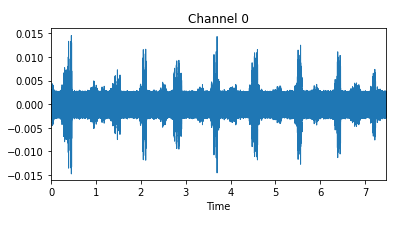

In [ ]:
at.show()

## Preparing the dataset

`fastai_audio` has a `AudioConfig` class which allows us to prepare different settings for our dataset. Currently it has:
* BasicMelSpectrogram
* BasicMFCC
* BasicSpectrogram
* Voice

We'll be converting all the audio into spectrograms. This is the data that will finally be used to train the model


In [ ]:
# configure
cfg = AudioConfig.BasicSpectrogram()    

In [ ]:
# create spectrogram
aud2spec = AudioToSpec.from_cfg(cfg)

In [ ]:
# pipeline for data

pipe = Pipeline([AudioTensor.create,aud2spec])

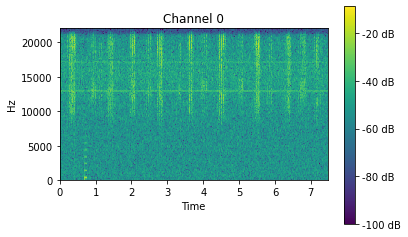

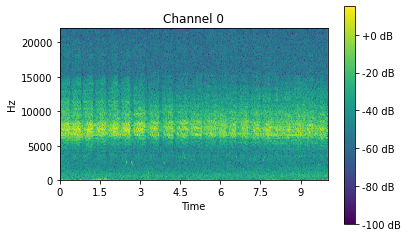

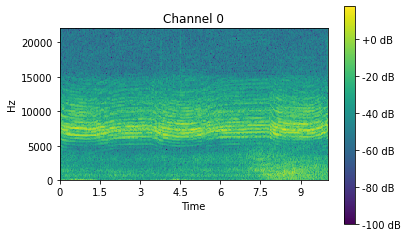

In [ ]:
# process a few files
for fn in fnames[:3]:
  audio = AudioTensor.create(fn)
  #audio.show()
  pipe(fn).show()

In [ ]:
# define how we want each item to be transformed.
# Resizing is necessary so all the samples are of the same length (in milliseconds)
itemTtfms = [ResizeSignal(7000),aud2spec]
# the classification is the first the first part of the file name
# Azanicadazuluensis_MHV%20936%20A.zuluensis%20Mission%20Rock%20%231.wav

In [ ]:
def getLabel(x):
  return x.name.split('_')[0]

In [ ]:
audData = DataBlock(
                    # define the type of files we're working with: audio with categorical data
                    blocks = (AudioBlock, CategoryBlock),
                    # get the files from: 
                    get_items = get_audio_files,
                    # train/test split
                    splitter=RandomSplitter(valid_pct = 0.2),
                    # transformations we want to apply to the data
                    item_tfms = itemTtfms,
                    # get the labels from the file names
                    get_y = getLabel)

In [ ]:
# load the data with batch size
dls = audData.dataloaders(Path(path), bs = 32)

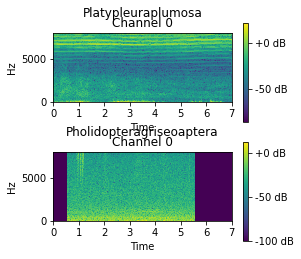

In [ ]:
dls.show_batch()

In [ ]:
# a function that changes a Learner's first layer to accept a 1 channel input 
def AlterLearner(learn, n_channels=1):
  "Adjust a `Learner`'s model to accept `1` channel"
  layer = learn.model[0][0]
  layer.in_channels=n_channels
  layer.weight = nn.Parameter(layer.weight[:,1,:,:].unsqueeze(1))
  learn.model[0][0] = layer

In [ ]:
learn = Learner(dls, xresnet18(), CrossEntropyLossFlat(), metrics = accuracy)

In [ ]:
# get the channels
nChans = dls.one_batch()[0].shape[1]; 

In [ ]:
nChans

1

In [ ]:
AlterLearner(learn,nChans)

In [ ]:
learn.fine_tune(3)

epoch,train_loss,valid_loss,accuracy,time
0,6.539359,5.865753,0.044118,00:10


epoch,train_loss,valid_loss,accuracy,time
0,4.293286,4.648650,0.191176,00:07
1,3.617277,3.392063,0.132353,00:09
2,3.135991,3.030432,0.220588,00:07


SuggestedLRs(lr_min=0.0019054606556892395, lr_steep=0.004365158267319202)

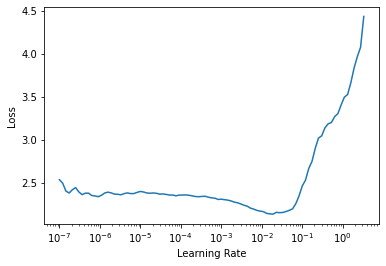

In [ ]:
#find the best learning rate
learn.lr_find(suggestions=True)

In [ ]:
learn.fit_one_cycle(10,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,2.176193,2.473671,0.264706,00:08
1,1.982899,12.625673,0.044118,00:07
2,2.046880,31.515629,0.029412,00:07
3,2.076211,46.283501,0.044118,00:09
4,1.992859,4.481312,0.220588,00:08
5,1.894426,2.684674,0.411765,00:07
6,1.754044,2.172450,0.426471,00:07
7,1.604691,1.931453,0.470588,00:07
8,1.500635,1.716398,0.529412,00:07
9,1.395543,1.657017,0.573529,00:07


In [ ]:
learn.export('audClassifier.pkl')

In [ ]:
learn.predict(AudioTensor.create(fnames[123]))

('Platypleuraplumosa',
 tensor(22),
 tensor([2.9652e-03, 3.0795e-03, 2.2583e-02, 4.6010e-03, 7.8677e-04, 2.1311e-03,
         2.1353e-02, 7.2677e-03, 9.0340e-03, 4.4601e-03, 1.9171e-02, 5.8184e-03,
         9.5880e-03, 4.2281e-03, 6.7380e-03, 3.9883e-02, 1.0461e-03, 5.6319e-03,
         1.4684e-02, 1.6289e-03, 1.5326e-01, 5.7432e-03, 3.0927e-01, 1.0513e-02,
         1.6353e-03, 1.0873e-02, 5.1473e-02, 1.9447e-01, 7.0348e-03, 1.2426e-02,
         8.0393e-03, 9.5880e-03, 3.5613e-05, 1.8762e-05, 2.7901e-05, 5.7821e-05,
         1.0082e-04, 1.1792e-05, 1.2789e-05, 2.9314e-05, 1.5060e-05, 3.9443e-04,
         3.4512e-05, 4.4387e-05, 1.9021e-05, 1.0706e-04, 2.0596e-05, 3.6295e-05,
         3.9685e-05, 1.6615e-05, 3.2116e-05, 3.5237e-05, 2.7039e-05, 5.6326e-05,
         1.4015e-05, 9.1655e-06, 3.6453e-05, 4.6596e-05, 4.5535e-05, 4.1145e-05,
         2.7513e-05, 2.5889e-05, 5.9514e-05, 6.3198e-05, 3.6141e-05, 4.3843e-05,
         2.0126e-05, 5.0682e-05, 7.4802e-05, 1.1178e-05, 1.8378e-05, 2.79